## Data Preprocessing
### Importing important libraries


In [4]:
import re
import regex
import pandas as pd
import numpy as np
import emoji
import plotly.express as px
from collections import Counter
import matplotlib.pyplot as plt
from os import path
from PIL import Image
import datetime
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
%matplotlib inline

### Data Preparation for analysing the whatsapp group chat
Tokenizing into {Date}{Time}-{Author}:{Message} format

In [5]:

def startsWithDateAndTimeAndroid(s):
    pattern = '^([0-9]+)(\/)([0-9]+)(\/)([0-9]+), ([0-9]+):([0-9]+)[ ]?(AM|PM|am|pm)? -' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

def startsWithDateAndTimeios(s):
    pattern = '^\[([0-9]+)([\/-])([0-9]+)([\/-])([0-9]+)[,]? ([0-9]+):([0-9][0-9]):([0-9][0-9])?[ ]?(AM|PM|am|pm)?\]' 
    result = re.match(pattern, s)
    if result:
        return True
    return False

In [6]:
def FindAuthor(s):
  s=s.split(":")
  if len(s)==2:
    return True
  else:
    return False

In [7]:
def getDataPointAndroid(line):   
    splitLine = line.split(' - ') 
    dateTime = splitLine[0]
    date, time = dateTime.split(', ') 
    message = ' '.join(splitLine[1:])
    if FindAuthor(message): 
        splitMessage = message.split(':') 
        author = splitMessage[0] 
        message = ' '.join(splitMessage[1:])
    else:
        author = None
    return date, time, author, message

def getDataPointios(line):
	splitLine = line.split('] ')
	dateTime = splitLine[0]
	if ',' in dateTime:
		date, time = dateTime.split(',')
	else:
		date, time = dateTime.split(' ')
	message = ' '.join(splitLine[1:])
	if FindAuthor(message):
		splitMessage = message.split(':')
		author = splitMessage[0]
		message = ' '.join(splitMessage[1:])
	else:
		author = None
	if time[5]==":":
		time = time[:5]+time[-3:]
	else:
		if 'AM' in time or 'PM' in time:
			time = time[:6]+time[-3:]
		else:
			time = time[:6]
	return date, time, author, message

In [8]:
def dateconv(date):
  year=''
  if '-' in date:
    year = date.split('-')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d-%m-%Y").strftime("%Y-%m-%d")
    elif len(year) ==2:
      return datetime.datetime.strptime(date, "[%d-%m-%y").strftime("%Y-%m-%d")
  elif '/' in date:
    year = date.split('/')[2]
    if len(year) == 4:
      return datetime.datetime.strptime(date, "[%d/%m/%Y").strftime("%Y-%m-%d")
    if len(year) ==2:
      return datetime.datetime.strptime(date, "[%d/%m/%y").strftime("%Y-%m-%d")

In [9]:
def split_count(text):

    emoji_list = []
    data = regex.findall(r'\X', text)
    for word in data:
        if any(char in emoji.UNICODE_EMOJI for char in word):
            emoji_list.append(word)

    return emoji_list

In [10]:
parsedData = [] # List to keep track of data so it can be used by a Pandas dataframe
conversationPath = '/Users/akashverma/Downloads/WhatsApp Chat with GRM @ANZ (2).txt' 
with open(conversationPath, encoding="utf-8") as fp:
    device=''
    first=fp.readline()
    print(first)
    if '[' in first:
      device='ios'
    else:
      device="android"
    fp.readline() 
    messageBuffer = [] 
    date, time, author = None, None, None
    while True:
        line = fp.readline() 
        if not line: 
            break
        if device=="ios":
          line = line.strip()
          if startsWithDateAndTimeios(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointios(line)
            messageBuffer.append(message)
          else:
            line= (line.encode('ascii', 'ignore')).decode("utf-8")
            if startsWithDateAndTimeios(line):
              if len(messageBuffer) > 0:
                parsedData.append([date, time, author, ' '.join(messageBuffer)])
              messageBuffer.clear()
              date, time, author, message = getDataPointios(line)
              messageBuffer.append(message)
            else:
              messageBuffer.append(line)
        else:
          line = line.strip()
          if startsWithDateAndTimeAndroid(line):
            if len(messageBuffer) > 0:
              parsedData.append([date, time, author, ' '.join(messageBuffer)])
            messageBuffer.clear()
            date, time, author, message = getDataPointAndroid(line)
            messageBuffer.append(message)
          else:
            messageBuffer.append(line)

19/06/17, 18:43 - AKASH ANZ created group "GRM @ANZ"



In [11]:
if device =='android':
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message'])
        df["Date"] = pd.to_datetime(df["Date"])
        df = df.dropna()
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()
else:
        df = pd.DataFrame(parsedData, columns=['Date', 'Time', 'Author', 'Message']) # Initialising a pandas Dataframe.
        df = df.dropna()
        df["Date"] = df["Date"].apply(dateconv)
        df["Date"] = pd.to_datetime(df["Date"],format='%Y-%m-%d')
        df["emoji"] = df["Message"].apply(split_count)
        URLPATTERN = r'(https?://\S+)'
        df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

### Observing the data frame created from the .txt file

In [47]:
df.head(10)

Date   Time   Author                                 Message    emoji  \
0 2017-01-09  07:48  SHAKTHI                                     🏃🏻🕰  [🏃🏻, 🕰]   
1 2017-01-09  07:53    TAPAN                                     🏃🏻☠  [🏃🏻, ☠]   
2 2017-01-09  07:54  SHAKTHI                       Terribly late ? 😜      [😜]   
3 2017-01-09  07:54    TAPAN              Yeah like Late Tapan Verma       []   
4 2017-01-09  07:54    TAPAN                           Abhi utha hun       []   
5 2017-01-09  07:55    TAPAN                                       😥      [😥]   
6 2017-01-09  07:55  SHAKTHI                                Hahaha 😂      [😂]   
7 2017-01-09  07:55  SHAKTHI             I missed my cab by 3 mins 🙈      [🙈]   
8 2017-01-09  08:16  SHREYAS                                      😂😂   [😂, 😂]   
9 2017-01-09  08:38   RITESH   Uber sucks. Coming from auto today. 😓      [😓]   

   urlcount  
0         0  
1         0  
2         0  
3         0  
4         0  
5         0  
6         0  
7         0  
8         0  
9         0

### Examining the number of unique participants in the chat group

In [18]:
df.Author.unique()

array(['SHAKTHI ANZ', 'TAPAN ANZ', 'Shreyas R', 'RITESH ANZ',
       'KRITIKA ANZ', 'ALOK ANZ', 'SAMANWITA ANZ', 'AKASH ANZ',
       'SUSHANT ANZ', 'RABIA ANZ', 'NIKITA ANZ', 'MAMTA ANZ'],
      dtype=object)

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29820 entries, 0 to 30534
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      29820 non-null  datetime64[ns]
 1   Time      29820 non-null  object        
 2   Author    29820 non-null  object        
 3   Message   29820 non-null  object        
 4   emoji     29820 non-null  object        
 5   urlcount  29820 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.6+ MB


In [20]:
df['Author']=df['Author'].replace(['SHAKTHI ANZ', 'TAPAN ANZ', 'Shreyas R', 'RITESH ANZ',
       'KRITIKA ANZ', 'ALOK ANZ', 'SAMANWITA ANZ', 'AKASH ANZ',
       'SUSHANT ANZ', 'RABIA ANZ', 'NIKITA ANZ', 'MAMTA ANZ'],['SHAKTHI', 'TAPAN', 'SHREYAS', 'RITESH',
       'KRITIKA', 'ALOK', 'SAMANWITA', 'AKASH',
       'SUSHANT', 'RABIA', 'NIKITA', 'MAMTA'])
df.Author.unique()

array(['SHAKTHI', 'TAPAN', 'SHREYAS', 'RITESH', 'KRITIKA', 'ALOK',
       'SAMANWITA', 'AKASH', 'SUSHANT', 'RABIA', 'NIKITA', 'MAMTA'],
      dtype=object)

### Total Messages exchanged in the group

In [48]:
total_messages = df.shape[0]
print(total_messages)

29820


In [49]:
df.shape

(29820, 6)

In [57]:
media_messages = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')].shape[0]

### Total Emojis exchanged

In [23]:
emojis = sum(df['emoji'].str.len())
print(emojis)

11878


In [24]:
URLPATTERN = r'(https?://\S+)'
df['urlcount'] = df.Message.apply(lambda x: re.findall(URLPATTERN, x)).str.len()

In [25]:
links = np.sum(df.urlcount)

### Overall Group Stats

In [58]:
print("Group Wise Stats")
print("Messages:",total_messages)
print("Media:",media_messages)
print("Emojis:",emojis)
print("Links:",links)

Group Wise Stats
Messages: 29820
Media: 2067
Emojis: 11878
Links: 45


### Creating different data frames from the base file

In [27]:
link_messages= df[df['urlcount']>0]
deleted_messages=df[(df["Message"] == " You deleted this message")| (df["Message"] == " This message was deleted.")|(df["Message"] == " You deleted this message.")]
media_messages_df = df[(df['Message'] == ' <Media omitted>')|(df['Message'] == ' image omitted')|(df['Message'] == ' video omitted')|(df['Message'] == ' sticker omitted')]
messages_df = df.drop(media_messages_df.index)
messages_df = messages_df.drop(deleted_messages.index)
messages_df = messages_df.drop(link_messages.index)

In [53]:
deleted_messages_num = deleted_messages.shape[0]
deleted_messages_num
media_messages_df.shape

(2067, 6)

In [29]:
messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27675 entries, 0 to 30534
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      27675 non-null  datetime64[ns]
 1   Time      27675 non-null  object        
 2   Author    27675 non-null  object        
 3   Message   27675 non-null  object        
 4   emoji     27675 non-null  object        
 5   urlcount  27675 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 1.5+ MB


In [30]:
media_messages_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2067 entries, 23 to 30528
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      2067 non-null   datetime64[ns]
 1   Time      2067 non-null   object        
 2   Author    2067 non-null   object        
 3   Message   2067 non-null   object        
 4   emoji     2067 non-null   object        
 5   urlcount  2067 non-null   int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 113.0+ KB


In [31]:

messages_df['Letter_Count'] = messages_df['Message'].apply(lambda s : len(s))
messages_df['Word_Count'] = messages_df['Message'].apply(lambda s : len(s.split(' ')))
messages_df["MessageCount"]=1

In [32]:
messages_df.head(2)

Date   Time   Author Message    emoji  urlcount  Letter_Count  \
0 2017-01-09  07:48  SHAKTHI     🏃🏻🕰  [🏃🏻, 🕰]         0             4   
1 2017-01-09  07:53    TAPAN     🏃🏻☠  [🏃🏻, ☠]         0             4   

   Word_Count  MessageCount  
0           2             1  
1           2             1

In [33]:
messages_df["emojicount"]= df['emoji'].str.len()

In [34]:
messages_df.head()

Date   Time   Author                      Message    emoji  urlcount  \
0 2017-01-09  07:48  SHAKTHI                          🏃🏻🕰  [🏃🏻, 🕰]         0   
1 2017-01-09  07:53    TAPAN                          🏃🏻☠  [🏃🏻, ☠]         0   
2 2017-01-09  07:54  SHAKTHI            Terribly late ? 😜      [😜]         0   
3 2017-01-09  07:54    TAPAN   Yeah like Late Tapan Verma       []         0   
4 2017-01-09  07:54    TAPAN                Abhi utha hun       []         0   

   Letter_Count  Word_Count  MessageCount  emojicount  
0             4           2             1           2  
1             4           2             1           2  
2            18           5             1           1  
3            27           6             1           0  
4            14           4             1           0

In [35]:
media_messages_df.head()
link_messages.head()

Date   Time   Author  \
1427 2017-10-31  21:27  SHAKTHI   
2275 2018-06-01  10:48  SHREYAS   
2276 2018-07-01  13:15  SHAKTHI   
2341 2018-01-17  17:45  SHREYAS   
3216 2018-05-13  11:36    AKASH   

                                                Message emoji  urlcount  
1427   Mystery Rooms  No. 1133, 2nd Flr, 100 Ft. Roa...    []         1  
2275   *Shreyas R* Sent You Special Love Calculator....  [❤️]         1  
2276   H2O Dance and Recording Studioz  CJR Arcade, ...    []         1  
2341   Post Office Bellandur Main Road, Bengaluru Ur...    []         1  
3216   State Central Library  Cubbon Park, Near Cent...    []         1

### Creating data frames for doing the summary statistics

In [36]:
df1=messages_df.groupby("Author")["MessageCount"].count().to_frame(name='Total Messages Sent').reset_index()
df2=messages_df.groupby("Author")["Word_Count"].sum().to_frame(name='Total Words').reset_index()
df3=media_messages_df.groupby("Author")["Author"].count().to_frame(name='Media Messages').reset_index()
df4=messages_df.groupby("Author")["emojicount"].sum().to_frame(name='Total Emojis Sent').reset_index()
df5=link_messages.groupby("Author")["Author"].count().to_frame(name='Total Links Sent').reset_index()

In [37]:
dfs=[df1,df2,df3,df4]
from functools import reduce
df_summary = reduce(lambda left,right: pd.merge(left,right,on='Author'), dfs)
df_summary["Avg words per message"]=df_summary["Total Words"]/df_summary["Total Messages Sent"]
del df_summary["Total Words"]
df_summary=df_summary.sort_values('Total Messages Sent',ascending=False).reset_index()
del df_summary["index"]
df_summary

Author  Total Messages Sent  Media Messages  Total Emojis Sent  \
0       TAPAN                 5547             529               1385   
1     SHAKTHI                 4048             215               2561   
2      RITESH                 3554             375               2382   
3     SHREYAS                 3540             396               1985   
4       AKASH                 3416             221                302   
5   SAMANWITA                 3219             102               1699   
6     SUSHANT                 2087              62                613   
7     KRITIKA                  896              83                566   
8        ALOK                  484              19                 55   
9       MAMTA                  365              53                129   
10      RABIA                  344               6                123   
11     NIKITA                  175               6                 73   

    Avg words per message  
0                6.987741  
1                6.876235  
2                9.191052  
3                7.211017  
4                6.156323  
5                6.085120  
6                8.390992  
7                5.380580  
8                6.747934  
9                5.821918  
10               6.662791  
11               6.314286

## Since we all love Emojis :)

### Emoji insights

In [38]:

total_emojis_list = list(set([a for b in messages_df.emoji for a in b]))
total_emojis = len(total_emojis_list)
print(total_emojis)

298


In [39]:

total_emojis_list = list([a for b in messages_df.emoji for a in b])
emoji_dict = dict(Counter(total_emojis_list))
emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
print(emoji_dict)

[('🤣', 2144), ('😂', 2116), ('😜', 830), ('😛', 688), ('😝', 634), ('😅', 612), ('🙈', 403), ('😬', 248), ('🤪', 211), ('😀', 210), ('🙄', 160), ('😃', 139), ('😳', 117), ('🤔', 114), ('😐', 107), ('😏', 101), ('🤭', 98), ('😋', 77), ('🤦\u200d♂️', 72), ('😎', 71), ('😁', 69), ('😶', 64), ('🤦🏻\u200d♀️', 59), ('🙊', 55), ('🤓', 54), ('😑', 53), ('👍', 53), ('👻', 53), ('😊', 52), ('🙁', 51), ('🤨', 51), ('😕', 50), ('🥺', 50), ('😭', 49), ('🥳', 44), ('🎉', 42), ('😢', 40), ('👆', 39), ('🤦🏼\u200d♂️', 38), ('😍', 37), ('👏', 36), ('🤦🏼\u200d♂', 35), ('🤦\u200d♂', 35), ('🤩', 35), ('☹', 34), ('😮', 33), ('👍🏼', 33), ('🙏', 33), ('👏🏻', 33), ('😒', 31), ('😉', 30), ('😄', 30), ('😆', 28), ('🎂', 28), ('😱', 27), ('😓', 26), ('🤘', 24), ('👌', 23), ('😯', 23), ('😇', 23), ('🕰', 22), ('😘', 22), ('🍻', 22), ('🏃🏻', 21), ('👆🏼', 21), ('🙌🏻', 21), ('👏🏼', 20), ('😣', 19), ('🧐', 19), ('😞', 18), ('😠', 18), ('👆🏻', 17), ('🙌🏼', 17), ('🙀', 17), ('✌🏻', 17), ('🤷🏼\u200d♂', 16), ('👍🏻', 16), ('😖', 16), ('☹️', 16), ('🙂', 15), ('🙏🏻', 14), ('🤷🏼\u200d♂️', 14), ('🤗', 13)

In [40]:

emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
emoji_df

emoji  count
0       🤣   2144
1       😂   2116
2       😜    830
3       😛    688
4       😝    634
..    ...    ...
293     🍼      1
294     ❓      1
295    🧔🏻      1
296     💎      1
297     ❌      1

[298 rows x 2 columns]

In [41]:
import plotly.express as px
fig = px.pie(emoji_df, values='count', names='emoji')
fig.update_traces(textposition='inside', textinfo='percent+label')
fig.show()

In [42]:
# Creates a list of unique Authors - ['Manikanta', 'Teja Kura', .........]
l = messages_df.Author.unique()
for i in range(len(l)):
  dummy_df = messages_df[messages_df['Author'] == l[i]]
  total_emojis_list = list([a for b in dummy_df.emoji for a in b])
  emoji_dict = dict(Counter(total_emojis_list))
  emoji_dict = sorted(emoji_dict.items(), key=lambda x: x[1], reverse=True)
  print('Emoji Distribution for', l[i])
  author_emoji_df = pd.DataFrame(emoji_dict, columns=['emoji', 'count'])
  fig = px.pie(author_emoji_df, values='count', names='emoji')
  fig.update_traces(textposition='inside', textinfo='percent+label')
  fig.show()

Emoji Distribution for SHAKTHI


Emoji Distribution for TAPAN


Emoji Distribution for SHREYAS


Emoji Distribution for RITESH


Emoji Distribution for KRITIKA


Emoji Distribution for ALOK


Emoji Distribution for AKASH


Emoji Distribution for SAMANWITA


Emoji Distribution for SUSHANT


Emoji Distribution for RABIA


Emoji Distribution for NIKITA


Emoji Distribution for MAMTA


### Activity Analysis

In [43]:
def f(i):
  l = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
  return l[i];
day_df=pd.DataFrame(messages_df["Message"])
day_df['day_of_date'] = messages_df['Date'].dt.weekday
day_df['day_of_date'] = day_df["day_of_date"].apply(f)
day_df["messagecount"] = 1
day = day_df.groupby("day_of_date").sum()
day.reset_index(inplace=True)

In [44]:
fig = px.line_polar(day, r='messagecount', theta='day_of_date', line_close=True)
fig.update_traces(fill='toself')
fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
    )),
  showlegend=False
)
fig.show()


### Lockdown effect

In [60]:

date_df = messages_df.groupby("Date").sum()
date_df.reset_index(inplace=True)
fig = px.line(date_df, x="Date", y="MessageCount")
fig.update_xaxes(nticks=20)
fig.show()

In [61]:

date_df["rolling"] = date_df["MessageCount"].rolling(30).mean()
fig = px.line(date_df, x="Date", y="rolling")
fig.update_xaxes(nticks=20)
fig.show()

In [59]:

auth = messages_df.groupby("Author").sum()
auth.reset_index(inplace=True)
fig = px.bar(auth, y="Author", x="MessageCount", color='Author', orientation="h",
             color_discrete_sequence=["red", "green", "blue", "goldenrod", "magenta"],
             title="Explicit color sequence"
            )

fig.show()

Text(0, 0.5, 'Time')

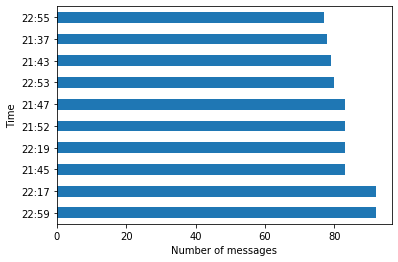

In [174]:

messages_df['Time'].value_counts().head(10).plot.barh() # Top 10 Times of the day at which the most number of messages were sent
plt.xlabel('Number of messages')
plt.ylabel('Time')

2020-02-06    543
2020-03-06    410
2020-04-30    406
2020-03-24    387
2020-12-06    351
             ... 
2017-10-21      1
2018-04-28      1
2019-04-28      1
2019-08-07      1
2019-12-17      1
Name: Date, Length: 729, dtype: int64


Text(0, 0.5, 'Date')

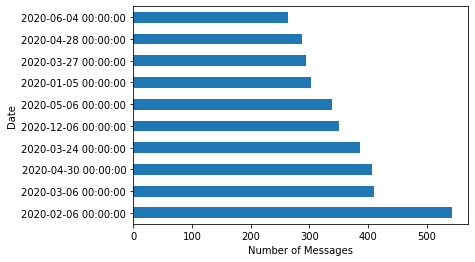

In [175]:
messages_df['Date'].value_counts().head(10).plot.barh()
print(messages_df['Date'].value_counts())
plt.xlabel('Number of Messages')
plt.ylabel('Date')

### Word Cloud

In [176]:
messages_df.iloc[messages_df['Word_Count'].argmax()]

Date                                          2017-09-25 00:00:00
Time                                                        19:31
Author                                                      TAPAN
Message          गिलक्रिस्ट और हेडेन का दिल दहलाने वाला कहर क्...
emoji                                                          []
urlcount                                                        0
Letter_Count                                                 2259
Word_Count                                                    491
MessageCount                                                    1
emojicount                                                      0
Name: 501, dtype: object

In [177]:
text = " ".join(review for review in messages_df.Message)
print ("There are {} words in all the messages.".format(len(text)))

There are 904481 words in all the messages.


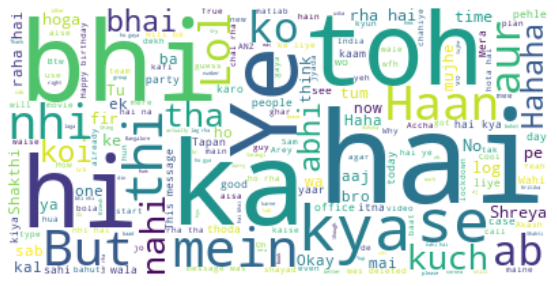

In [179]:
stopwords = set(STOPWORDS)
stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","la","eh","ne","le","ni","lo","Ma","Haa","ni"])
# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
# Display the generated image:
# the matplotlib way:
  
plt.figure( figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Author name SHAKTHI


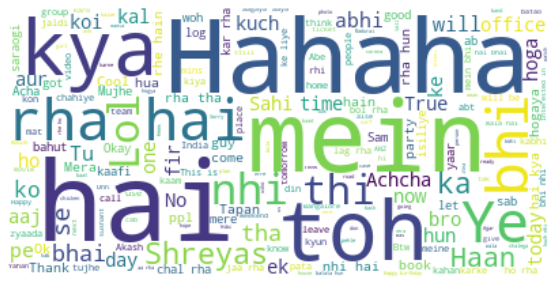

Author name TAPAN


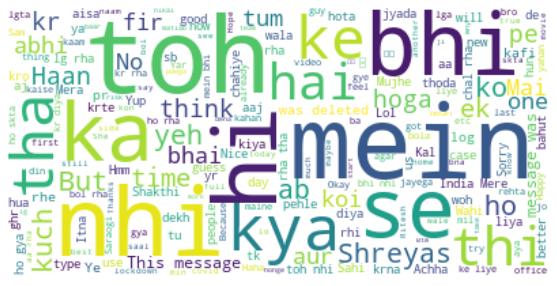

Author name SHREYAS


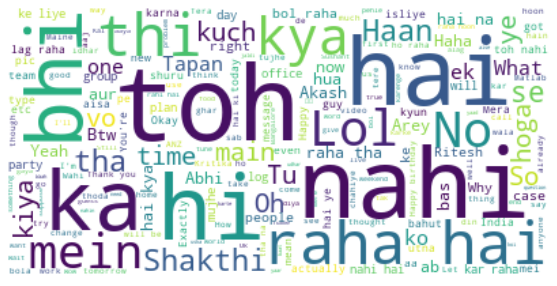

Author name RITESH


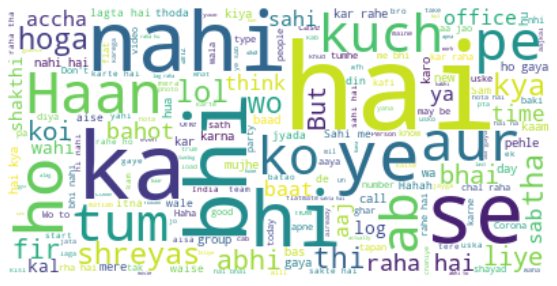

Author name KRITIKA


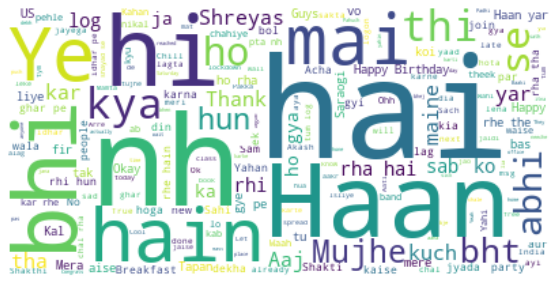

Author name ALOK


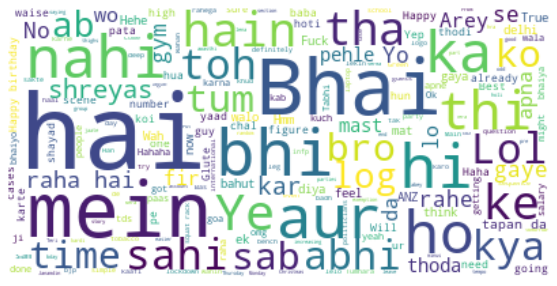

Author name AKASH


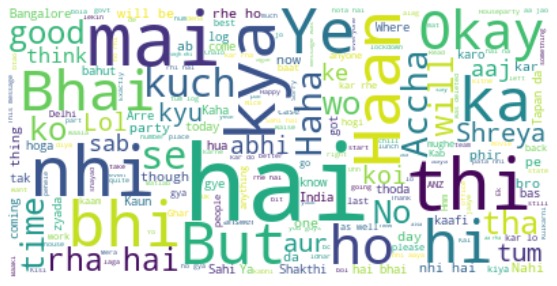

Author name SAMANWITA


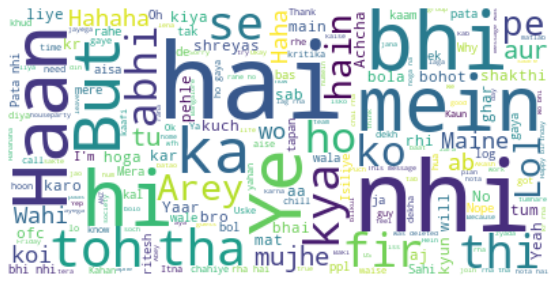

Author name SUSHANT


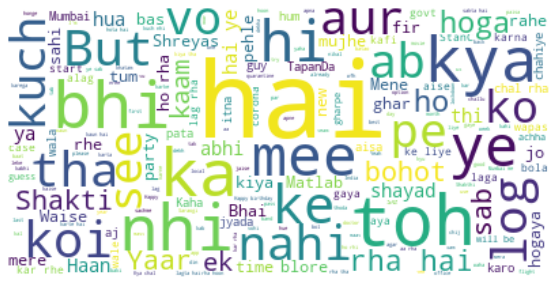

Author name RABIA


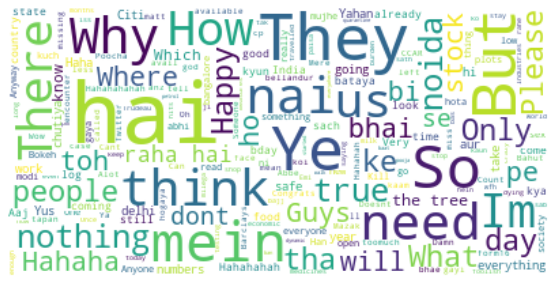

Author name NIKITA


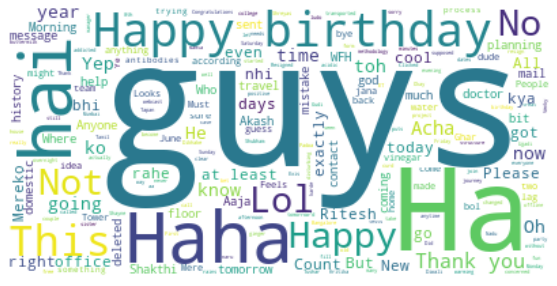

Author name MAMTA


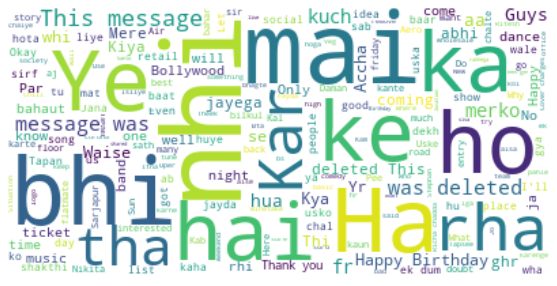

In [180]:
 l = messages_df.Author.unique()
 for i in range(len(l)):
   dummy_df = messages_df[messages_df['Author'] == l[i]]
   text = " ".join(review for review in dummy_df.Message)
   stopwords = set(STOPWORDS)
   stopwords.update(["ra", "ga", "na", "ani", "em", "ki", "ah","ha","anta","kuda","ante","la","eh","Nen","ne","haa","Haa","le"])
   # Generate a word cloud image
   print('Author name',l[i])
   wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
   # Display the generated image:
   # the matplotlib way:
  
   plt.figure( figsize=(10,5))
   plt.imshow(wordcloud, interpolation='bilinear')
   plt.axis("off")
   plt.show()